# IT Academy - Data Science amb Python
## Tasca 7: Estructura de control

###  [Github Registre de Logs](https://github.com/jesussantana/Registre_de_logs)

###  Exercici 1
- Normalitza, identifica i enumera cada un dels atributs / variables de l'estructura de l'arxiu "Web_access_log-akumenius.com" que trobaràs al repositori de GitHub "Data-sources".

In [1]:
import numpy as np
import pandas as pd
import requests
import re

pd.set_option('display.max_columns', None)

In [2]:
path = '../Data/Web_access_log-akumenius.com.txt'

Logs = pd.read_csv(path, sep='\s | \- | \"', names =['DNS','IP','Location','Date','Time','Request','Status','Size','Referer','UserAgent'], skiprows=261771, engine='python')

Logs_copy = Logs.copy()

Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/F...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
1,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/b...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
2,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/F...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
3,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/b...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
4,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/b...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
97,www.akumenius.com 5.255.253.53,- [02/Mar/2014:03:05:39 +0100],"GET / HTTP/1.1"" 200 7528","-""",Mozilla/5.0 (compatible; YandexBot/3.0; +http:...,NaN,NaN,NaN,NaN,NaN
98,www.akumenius.com 74.86.158.107,- [02/Mar/2014:03:09:52 +0100],"HEAD / HTTP/1.1"" 200","""-""",Mozilla/5.0+(compatible; UptimeRobot/2.0; http...,NaN,NaN,NaN,NaN,NaN
99,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN
100,localhost 127.0.0.1,- [02/Mar/2014:03:10:18 +0100],"OPTIONS * HTTP/1.0"" 200","""-""","Apache (internal dummy connection)"" VLOG=-",NaN,NaN,NaN,NaN,NaN


###  Exercici 2
- Neteja, preprocesa, estructura i transforma (dataframe) les dades del registre d'Accés a la web.

In [3]:
Logs_copy.shape

(102, 10)

In [4]:
Logs_copy.isnull().sum()

DNS            0
IP             0
Location       0
Date           0
Time           0
Request      102
Status       102
Size         102
Referer      102
UserAgent    102
dtype: int64

In [5]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/F...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
1,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/b...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
2,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/F...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
3,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/b...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN
4,www.akumenius.com 79.155.78.117,- [02/Mar/2014:02:30:23 +0100],GET /modules/raton/views/themes/bcoos/images/b...,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,NaN,NaN,NaN,NaN,NaN


In [6]:
# Reorder columns of data

Logs_copy.UserAgent = Logs_copy.Time
Logs_copy.Request = Logs_copy.Location
Logs_copy.Referer = Logs_copy.Date
Logs_copy.Date = Logs_copy.IP
Logs_copy.Time = Logs_copy.IP = np.nan
Logs_copy.Location = ""

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com 79.155.78.117,NaN,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/F...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,www.akumenius.com 79.155.78.117,NaN,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,www.akumenius.com 79.155.78.117,NaN,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/F...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,www.akumenius.com 79.155.78.117,NaN,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,www.akumenius.com 79.155.78.117,NaN,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


In [7]:
# DNS & IP data split

Logs_copy[['DNS','IP']] = Logs_copy.DNS.str.split('\s', expand = True).get([0, 1])

In [8]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,79.155.78.117,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/F...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,www.akumenius.com,79.155.78.117,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,www.akumenius.com,79.155.78.117,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/F...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,www.akumenius.com,79.155.78.117,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,www.akumenius.com,79.155.78.117,,- [02/Mar/2014:02:30:23 +0100],NaN,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


In [9]:
Logs_copy.DNS.unique()

array(['www.akumenius.com', 'localhost', 'akumenius.com', 'akumenius.es'],
      dtype=object)

In [10]:
# Time data extraction

Logs_copy.Time = Logs_copy.Date.str.extract(':(\d{2}:\d{2}:\d{2}.*)]')

In [11]:
# Date data extraction

Logs_copy.Date= Logs_copy.Date.str.extract('(\d+/\w+/\d+)')

In [12]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,NaN,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


In [13]:
# Request & Status data split

Logs_copy[['Request','Status']] = Logs_copy.Request.str.split('\"', expand = True).get([0, 1])

In [14]:
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200 1169,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200 2167,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200 1047,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200 2540,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200 614,NaN,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


In [15]:
# Size data extraction

Logs_copy.Size = Logs_copy.Status.str.extract('(\d+$)')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200 1169,1169,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200 2167,2167,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200 1047,1047,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200 2540,2540,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200 614,614,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


In [16]:
# Status data extraction

Logs_copy.Status = Logs_copy.Status.str.extract('(\d{3})')
Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1169,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2167,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1047,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2540,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,614,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


In [17]:
# Referer useless data correction

for index, row in Logs_copy.iterrows(): 
    
    if row.Referer == '"-"' or row.Referer == '-"':
        row.Referer = ""
                
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1169,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2167,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1047,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2540,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,www.akumenius.com,79.155.78.117,,02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,614,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
...,...,...,...,...,...,...,...,...,...,...
97,www.akumenius.com,5.255.253.53,,02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
98,www.akumenius.com,74.86.158.107,,02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,200,,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
99,localhost,127.0.0.1,,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,200,,"Apache (internal dummy connection)"" VLOG=-"
100,localhost,127.0.0.1,,02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,200,,"Apache (internal dummy connection)"" VLOG=-"


###  Exercici 3
- Geolocalitza les IP's. Aqui tens una pagina de interes:
  - [IP2Locattion](https://blog.ip2location.com/knowledge-base/how-to-add-a-sub-account-in-ip2location/)

In [18]:
import json
from ip2geotools.databases.noncommercial import DbIpCity

In [19]:
# Extract Ips

ips = Logs_copy.IP.unique()
ips

array(['79.155.78.117', '127.0.0.1', '176.31.255.177', '66.249.76.216',
       '157.55.32.185', '74.86.158.106', '194.30.26.30',
       '217.174.248.179', '217.12.28.5', '157.55.34.173', '74.86.158.107',
       '180.76.5.200', '157.56.92.174', '217.12.28.130', '188.135.173.80',
       '180.76.6.37', '180.76.5.78', '83.45.25.198', '220.181.108.104',
       '123.125.71.52', '66.249.75.148', '206.198.5.33', '5.255.253.53'],
      dtype=object)

In [20]:
# Function for extract Locations

localhost = "127.0.0.1"

def extract_location(ip):
    
    try:
        if ip == localhost:
            return ('Local', 'Local')

        else:
            response = DbIpCity.get(ip, api_key = 'free').to_json()    
            data = json.loads(response)
            return data['city'], data['country']
    
    except:
        return np.nan

In [21]:
# Extract Location Test

extract_location(Logs_copy.IP[50])

('Beijing', 'CN')

In [22]:
# List of locations for unique Ips

locations = []

for element in ips:
    
    locations.append(extract_location(element))  

locations

[('San Cristóbal de La Laguna', 'ES'),
 ('Local', 'Local'),
 ('Roubaix', 'FR'),
 ('Mountain View', 'US'),
 ('Newark', 'US'),
 ('Chicago', 'US'),
 ('Ceuta', 'ES'),
 ('Gloucester', 'GB'),
 ('Seville', 'ES'),
 ('Newark', 'US'),
 ('Chicago', 'US'),
 ('Beijing', 'CN'),
 ('Newark', 'US'),
 ('Seville', 'ES'),
 ('Lecce', 'IT'),
 ('Beijing', 'CN'),
 ('Beijing', 'CN'),
 ('Madrid', 'ES'),
 ('Beijing', 'CN'),
 ('Haidian (Haidian Qu)', 'CN'),
 ('Mountain View', 'US'),
 ('Lincolnshire', 'US'),
 ('Moscow (Tsentralnyy administrativnyy okrug)', 'RU')]

In [23]:
# Compare ips & add location

for index, row in Logs_copy.iterrows():
    
    # iterate the two lists
    for a, b in zip(ips, locations):
        
        # Compare & add
        if row.IP == a:
            row.Location = b

In [24]:
Logs_copy

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent
0,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1169,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
1,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2167,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
2,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1047,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
3,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2540,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
4,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,614,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
...,...,...,...,...,...,...,...,...,...,...
97,www.akumenius.com,5.255.253.53,"(Moscow (Tsentralnyy administrativnyy okrug), RU)",02/Mar/2014,03:05:39 +0100,GET / HTTP/1.1,200,7528,,Mozilla/5.0 (compatible; YandexBot/3.0; +http:...
98,www.akumenius.com,74.86.158.107,"(Chicago, US)",02/Mar/2014,03:09:52 +0100,HEAD / HTTP/1.1,200,200,,Mozilla/5.0+(compatible; UptimeRobot/2.0; http...
99,localhost,127.0.0.1,"(Local, Local)",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,200,,"Apache (internal dummy connection)"" VLOG=-"
100,localhost,127.0.0.1,"(Local, Local)",02/Mar/2014,03:10:18 +0100,OPTIONS * HTTP/1.0,200,200,,"Apache (internal dummy connection)"" VLOG=-"


In [25]:
# Extract UserAgent Data

from device_detector import SoftwareDetector

Devices = Logs_copy['UserAgent']

device = []

for x in Devices:
    device.append(SoftwareDetector(x).parse())

client_name = []
client_type = []
client_version = []
os_name = []
os_version = []
device_type = []

for x in device:
    client_name.append(x.client_name())
    client_type.append(x.client_type())
    client_version.append(x.client_version())
    os_name.append(x.os_name())
    os_version.append(x.os_version())
    device_type.append(x.device_type())

Logs_copy['Client Name'] = client_name
Logs_copy['Client Type'] = client_type
Logs_copy['Client Version'] = client_version
Logs_copy['Os Name'] = os_name
Logs_copy['Os version'] = os_version
Logs_copy['Device Type'] = device_type

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,UserAgent,Client Name,Client Type,Client Version,Os Name,Os version,Device Type
0,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1169,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Chrome,browser,33.0.1750.117,Windows,7,desktop
1,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2167,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Chrome,browser,33.0.1750.117,Windows,7,desktop
2,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1047,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Chrome,browser,33.0.1750.117,Windows,7,desktop
3,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2540,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Chrome,browser,33.0.1750.117,Windows,7,desktop
4,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,614,http://www.akumenius.com/destinos-baratos/dest...,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Chrome,browser,33.0.1750.117,Windows,7,desktop


In [26]:
Logs_copy.UserAgent[0]

'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/33.0.1750.117 Safari/537.36" VLOG=-'

In [27]:
del(Logs_copy['UserAgent'])

Logs_copy.head()

,DNS,IP,Location,Date,Time,Request,Status,Size,Referer,Client Name,Client Type,Client Version,Os Name,Os version,Device Type
0,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1169,http://www.akumenius.com/destinos-baratos/dest...,Chrome,browser,33.0.1750.117,Windows,7,desktop
1,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2167,http://www.akumenius.com/destinos-baratos/dest...,Chrome,browser,33.0.1750.117,Windows,7,desktop
2,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/F...,200,1047,http://www.akumenius.com/destinos-baratos/dest...,Chrome,browser,33.0.1750.117,Windows,7,desktop
3,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,2540,http://www.akumenius.com/destinos-baratos/dest...,Chrome,browser,33.0.1750.117,Windows,7,desktop
4,www.akumenius.com,79.155.78.117,"(San Cristóbal de La Laguna, ES)",02/Mar/2014,02:30:23 +0100,GET /modules/raton/views/themes/bcoos/images/b...,200,614,http://www.akumenius.com/destinos-baratos/dest...,Chrome,browser,33.0.1750.117,Windows,7,desktop


###  Exercici 4
- Mostreu-me la teva creativitat, Sorprèn-me fes un pas més enllà amb el analysis anterior.

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

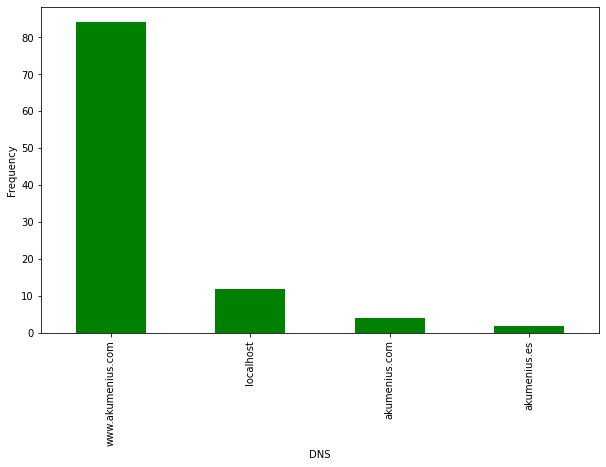

In [29]:
graph = Logs_copy[['DNS', 'Date']].groupby(['DNS']).count().sort_values(by = 'Date',ascending = False)
graph = graph.rename(columns = {'Date' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'green', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

<AxesSubplot:ylabel='DNS'>

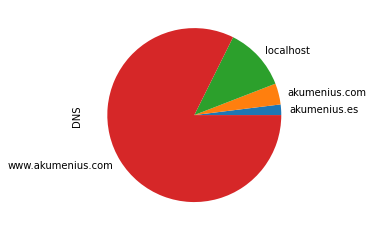

In [30]:
Logs_copy.DNS.value_counts(ascending = True).plot(kind = 'pie')

<AxesSubplot:>

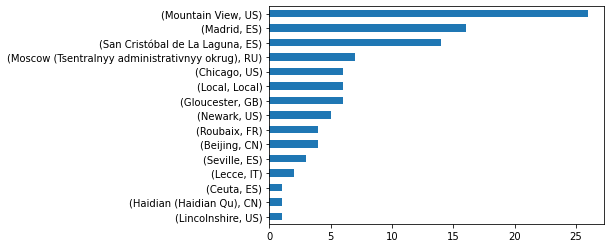

In [32]:
Logs_copy.Location.value_counts(ascending = True).plot(kind = 'barh')

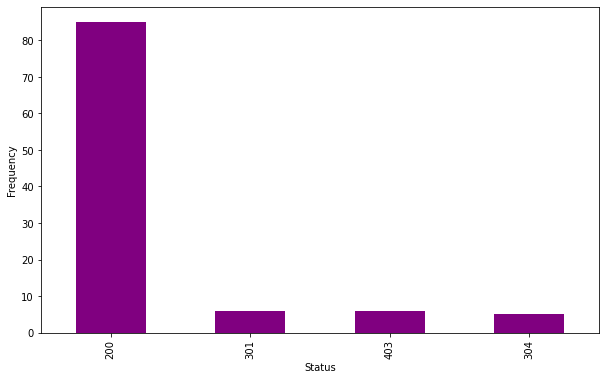

In [31]:
graph = Logs_copy[['Status', 'Date']].groupby(['Status']).count().sort_values(by = 'Date',ascending = False)
graph = graph.rename(columns = {'Date' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'Purple', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

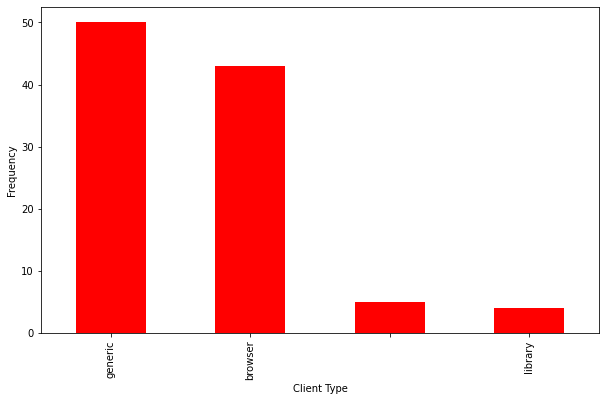

In [33]:
graph = Logs_copy[['Client Type','Date']].groupby(['Client Type']).count().sort_values(by = 'Date',ascending = False)
graph = graph.rename(columns = {'Date' : 'Frequency'})
graph.plot.bar(y = 'Frequency', color = 'red', ylabel = 'Frequency', legend = None, figsize = (10,6))
plt.show()

In [34]:
Logs_export = Logs_copy.copy()

Logs_export.replace('','null',inplace=True)

Logs_export.to_csv('../Data/Logs_export.csv',index=False)